In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch'

## 加载预训练模型

In [2]:
IMG_SIZE = (512, 512)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3094
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model.load_state_dict(torch.load('models/resnet50_512_best.pth'))
model.to(device)
model.eval()

NameError: name 'torch' is not defined

## 获取AvgPool的值

In [3]:
feat_act = {}
def get_activation(name):
    def hook(model, input, output):
        feat_act[name] = output.detach()
    return hook
model.avgpool.register_forward_hook(get_activation('avgpool'))

NameError: name 'model' is not defined

## 特征提取

In [9]:
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_fns, data_transforms):
        self.image_fns = image_fns
        self.transforms = data_transforms
    
    def __getitem__(self, index):
        fp = self.image_fns[index]
        fn = os.path.basename(fp)
        image = Image.open(fp).convert("RGB")
        
        # Preprocessing
        image = self.transforms(image)
        
        return image, fn
    
    def __len__(self):
        return len(self.image_fns)

import numpy as np
TEST_BATCH_SZIE = 64
d=2048
TEST_DATASET_PATH = '../dataset/test_data_A/'
gallery_image_fns = glob(os.path.join(TEST_DATASET_PATH, 'gallery', '*.*'))
print(gallery_image_fns[:10])
query_image_fns = glob(os.path.join(TEST_DATASET_PATH, 'query', '*.*'))

test_transform = transforms.Compose([
     transforms.Scale(IMG_SIZE[0]),
     transforms.CenterCrop(IMG_SIZE[0]),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

gallery_dataset = TestImageDataset(gallery_image_fns, test_transform)
gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_size=TEST_BATCH_SZIE,
                                          shuffle=True, num_workers=20)

query_dataset = TestImageDataset(query_image_fns, test_transform)
query_loader = torch.utils.data.DataLoader(query_dataset, batch_size=TEST_BATCH_SZIE,
                                          shuffle=True, num_workers=20)

gallery_vector = []
gallery_fns = []
query_vector = []
query_fns = []
with torch.no_grad():
    for img, fn in tqdm(gallery_loader):
        logits = torch.nn.Softmax()(model(img.to(device))).cpu().numpy()
        vectors = feat_act['avgpool'].view((-1, d,)).cpu().numpy()
        for v, n, l in zip(vectors, fn, logits):
            # print(np.sum(l**2))
            if np.sum(l**2) > 0.06:
                gallery_vector.append(v)
                gallery_fns.append(n)
    
    for img, fn in tqdm(query_loader):
        _ = torch.nn.Softmax()(model(img.to(device))).cpu().numpy()
        vectors = feat_act['avgpool'].view((-1, d,)).cpu().numpy()
        for v, n in zip(vectors, fn):
            query_vector.append(v)
            query_fns.append(n)
    
    gallery_vector = np.array(gallery_vector)
    query_vector = np.array(query_vector)

  0%|          | 0/779 [00:00<?, ?it/s]

['../dataset/test_data_A/gallery/UHZ5JYLDWF714K20.jpg', '../dataset/test_data_A/gallery/WOP4MLRAJGVD0F7H.jpg', '../dataset/test_data_A/gallery/65TWSBYN9UFJGIRD.jpg', '../dataset/test_data_A/gallery/PEGSBYA1D4NOF05R.jpg', '../dataset/test_data_A/gallery/M94QCBWYVS8DP652.jpg', '../dataset/test_data_A/gallery/7NHLEDQ6JG5K42A0.jpg', '../dataset/test_data_A/gallery/TDWIR4XO2BN8H1Z3.jpg', '../dataset/test_data_A/gallery/FD1GQ860JASWP4HI.jpg', '../dataset/test_data_A/gallery/XLVH2FKCAUJTP0M8.jpg', '../dataset/test_data_A/gallery/GZIFASPNROQ3B6K1.jpg']


/home/meirtz/anaconda3/envs/vision/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 150/150 [00:58<00:00,  2.58it/s]


## 保存特征

In [5]:
# gallery_vector = np.save('gallery_vector.npy',gallery_vector,allow_pickle = True)
# query_vector = np.save('query_vector.npy',query_vector,allow_pickle = True)

## 加载保存好的特征

In [6]:
gallery_vector = np.load('gallery_vector.npy')
query_vector = np.load('query_vector.npy')

## 向量匹配

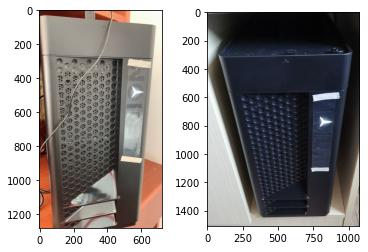

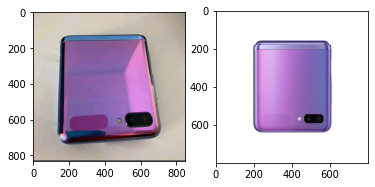

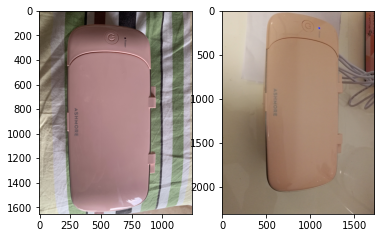

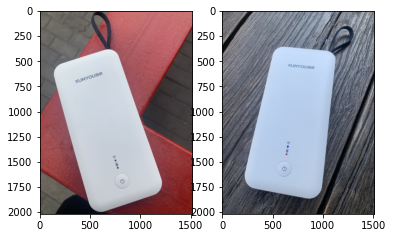

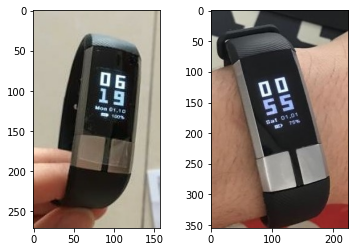

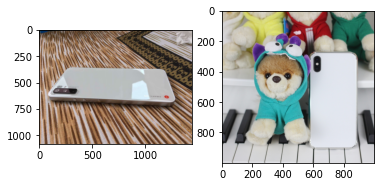

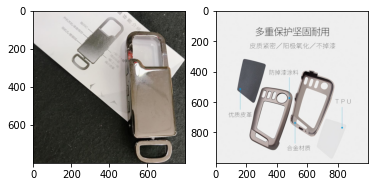

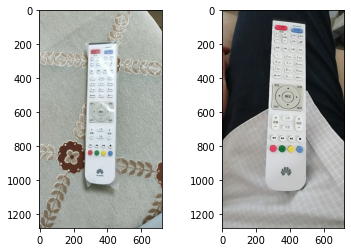

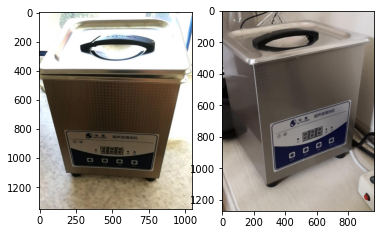

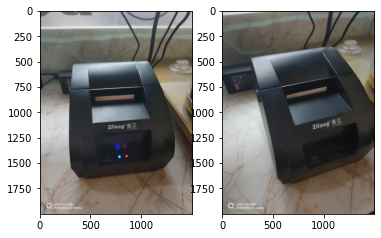

In [10]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(d)   # build the index
index.add(gallery_vector)                  # add vectors to the index

k = 10                          # we want to see 10 nearest neighbors

D, I = index.search(query_vector, k)     # actual search

result = ''
display_num = 10
for indices, distances, q_fn in zip(I, D, query_fns):
    line = q_fn+',{'
    
    # Visualization
    if display_num > 0:
        q_img = cv2.imread(os.path.join(TEST_DATASET_PATH, 'query', q_fn))[...,::-1].copy()
        g_img = cv2.imread(os.path.join(TEST_DATASET_PATH, 'gallery', gallery_fns[indices[0]]))[...,::-1].copy()
        f = plt.figure()
        f.add_subplot(1,2,1)
        plt.imshow(q_img)
        f.add_subplot(1,2,2)
        plt.imshow(g_img)
        plt.show()
        display_num -= 1
    # Visualization done     
    
    for i, dis in zip(indices, distances):
        #print(_d)
        # if dis-distances[0] > 200:
        #    break
        line+=gallery_fns[i]+','
    line = line[:-1]+'}\n'
    result+=line

## 保存到CSV文件

In [11]:
with open('submission.csv', 'a') as f:
    f.truncate(0)
    f.write(result)
    f.close()